In [32]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import image_to_train as tr
from model import get_model
import test_func as test
import time

In [33]:
# load desired model
model = get_model()
x2_weight_path = os.path.join('saved_weights', 'Weightx2', 'x2.ckpt')
model = test.load_x2_from_weights(model, x2_weight_path)

In [34]:
# working with bigger datasets can cause memory issues; limit the number of images you generate by indexing the images
# else, set the value of try_all_images = True
start_idx = 0
end_idx = 20
try_all_images = False
dataset_path = os.path.join('Urban 100', 'X2 Urban100', 'X2', 'LOW X2 Urban')
out_path = os.path.join('Urban 100', 'X2 Urban100', 'X2', 'SR X2 Urban')

if try_all_images:
    image_paths = [os.path.join(dataset_path, f) for f in sorted(os.listdir(dataset_path))]
else:
    image_paths = [os.path.join(dataset_path, f) for f in sorted(os.listdir(dataset_path))[start_idx:end_idx]]

(-0.5, 255.5, 160.5, -0.5)

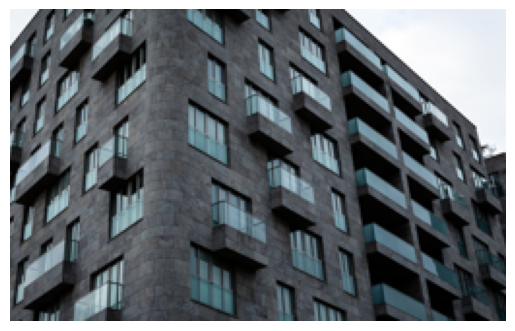

In [35]:
def read_and_decode(path):
    im = tf.io.read_file(path)
    im = tf.image.decode_image(im, channels=3)
    return im
rgb_images = [read_and_decode(path) for path in image_paths]
images = [tr.preprocess_single_image(im, channel_last=True) for im in rgb_images]
plt.imshow(rgb_images[0])
plt.axis('off')

In [36]:
images[0].shape

(1, 161, 256, 4)

In [37]:
# get SR sub-band residuals
predictions = []
for image in images:
    prediction = model.predict(image, verbose=0)
    predictions.append(tf.squeeze(prediction))

2024-02-27 12:15:39.518691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-27 12:15:39.650316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-27 12:15:40.249255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [38]:
# add residuals to LR image and convert sub-bands to luminance image
squeezed_images = [tf.squeeze(im) for im in images]
SR_bands = [im + pred for im, pred in zip(squeezed_images, predictions)]
SR_lum = []
for bands in SR_bands:
    SR_lum.append(tr.bands_to_image(bands))

In [39]:
# convert luminance to rgb
SR_rgb_images = [test.luminance_to_rgb(lum, rgb) for lum, rgb in zip(SR_lum, rgb_images)]

(-0.5, 511.5, 321.5, -0.5)

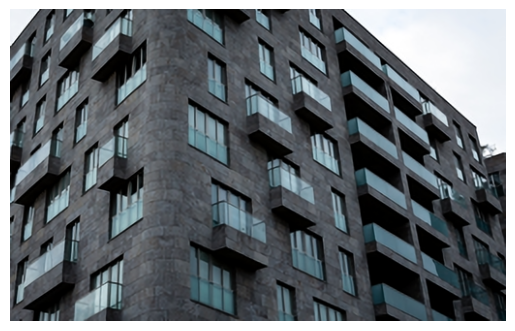

In [40]:
# confirm images
plt.imshow(SR_rgb_images[0])
plt.axis('off')

In [41]:
# store results in out_path directory
file_names = ['{:03d}'.format(i) for i in range(start_idx+1, end_idx+1)]
test.write_images_to_path(out_path, SR_rgb_images, file_names)